In [119]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), get_dummies

import random
import shap

from statistics import mean

import matplotlib.pyplot as plt  # for charts

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate

import rbo # rank-biased overlap to be used for faithfulness


In [120]:
# Import Data

datafolder = r"C:\Users\garry\PycharmProjects\Final Paper\Data"
X = pd.read_csv(datafolder + "\credit_card_transactions-ibm.csv")
y = pd.read_csv(datafolder + "\credit_card_transactions-ibm-target.csv")

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 28 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0                   10000 non-null  int64  
 1   User                         10000 non-null  int64  
 2   Card                         10000 non-null  int64  
 3   Amount                       10000 non-null  float64
 4   Merchant City                10000 non-null  float64
 5   MCC                          10000 non-null  int64  
 6   Errors?                      10000 non-null  int64  
 7   timestamp                    10000 non-null  int64  
 8   CARD INDEX                   10000 non-null  int64  
 9   Cards Issued                 10000 non-null  int64  
 10  Latitude                     10000 non-null  float64
 11  Longitude                    10000 non-null  float64
 12  FICO Score                   10000 non-null  int64  
 13  Num Credit Cards 

In [121]:
y.describe()

,Unnamed: 0,Is Fraud?
count,1.000000e+04,10000.000000
mean,1.224250e+07,0.250000
std,7.020726e+06,0.433034
min,8.520000e+02,0.000000
25%,6.182418e+06,0.000000
50%,1.216958e+07,0.000000
75%,1.840669e+07,0.250000
max,2.437660e+07,1.000000


In [122]:
y["Is Fraud?"].value_counts()

Is Fraud?
0    7500
1    2500
Name: count, dtype: int64

In [123]:
# Split the resampled data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y.iloc[:,1], test_size=0.2, stratify=y.iloc[:,1], random_state = 42)

In [124]:
#Build Random Forest model
RF_model = RandomForestClassifier(n_estimators=150, random_state=0)

#Create Stratified K-fold cross validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [125]:
# Define the scoring parameters:
scoring = ('f1', 'recall', 'precision')

#Evaluate RF_model via the scores
scores = cross_validate(RF_model, X_train, y_train.values.ravel(), scoring=scoring, cv=cv)

In [126]:
#Get average evaluation metrics
print('Mean f1: %.3f' % mean(scores['test_f1']))
print('Mean recall: %.3f' % mean(scores['test_recall']))
print('Mean precision: %.3f' % mean(scores['test_precision']))

Mean f1: 0.844
Mean recall: 0.790
Mean precision: 0.907


In [127]:
#Train RF_model on the full training set
RF_model.fit(X_train, y_train.values.ravel())

RandomForestClassifier(n_estimators=150, random_state=0)

In [128]:
## RF_model prediction
y_pred = RF_model.predict(X_test)

Text(0.5, 1.0, 'Random Forest Confusion Matrix')

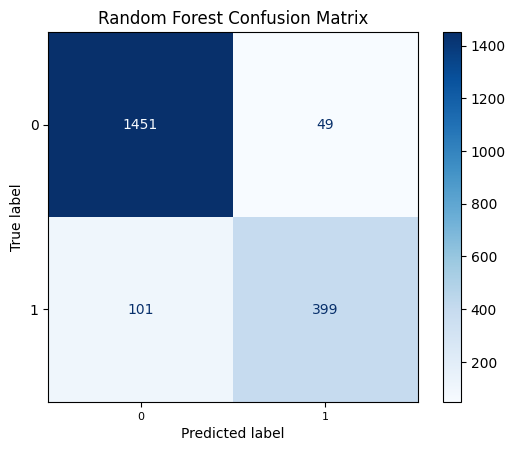

In [129]:
#Create confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=RF_model.classes_)
fig = ConfusionMatrixDisplay(cm, display_labels=RF_model.classes_)
fig.plot(cmap=plt.cm.Blues)
fig.ax_.set_title('Random Forest Confusion Matrix')

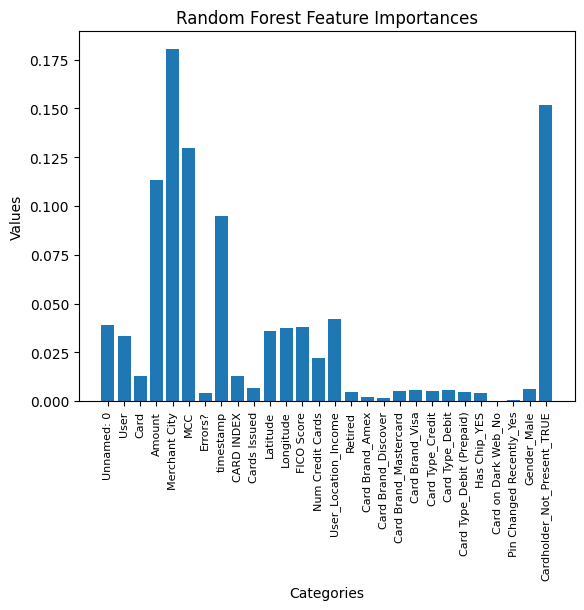

In [130]:
# Produce a Bar Chart with the feature importances:

# Set font sizes
small = 8
medium = 10
large = 12

# Get feature importances
feature_importances = RF_model.feature_importances_
RF_model.feature_names = list(X_train.columns.values)

# Sample data
categories = RF_model.feature_names
values = feature_importances

# Create bar chart
plt.bar(categories, values)

# Add title and labels
plt.rc('xtick', labelsize = small)    # fontsize of the tick labels
plt.title('Random Forest Feature Importances')
plt.xlabel('Categories')
plt.ylabel('Values')

# Rotating X-axis labels
plt.xticks(rotation = 90)

# Show the plot
plt.show()

In [131]:
# For SHAP purposes, randomly select a transaction from X_test that we know is predicted to be fraud (because we only want an explanation when a fraud prediction is provided):

# select all the rows which are designated fraud (provides a tuple):
fraud_pred = np.where(y_pred==1)

# convert tuple to an array and then transpose
fraud_array = np.array(fraud_pred)
new = np.transpose(fraud_array)

# select an instance (index value) at random
single_fraud_instance = random.choice(new)

# Use that single fraud instance index value to get the original transaction from X_test: 

single_instance = X_test.iloc[single_fraud_instance]
single_instance_prediction = y_pred[single_fraud_instance]

# Turn the prediction into text:

if single_instance_prediction == 1:
    single_instance_prediction_text = "FRAUDULENT"
else:
    single_instance_prediction_text = "LEGITIMATE"

print("The transaction represented by index ",single_fraud_instance," is predicted to be ",single_instance_prediction_text)

The transaction represented by index  [663]  is predicted to be  FRAUDULENT


In [132]:
## Then Apply SHAP
# https://shap-lrjball.readthedocs.io/en/latest/generated/shap.TreeExplainer.html

# Load JS visualization code to notebook
shap.initjs()

# Create an explainer object using the random forest model
#explainer = shap.TreeExplainer(RF_model,X_test, model_output="raw", feature_perturbation='interventional')
explainer = shap.TreeExplainer(RF_model)

shap_values_global = explainer(X_test)
shap_values_local = explainer(single_instance)

In [133]:
expected_value = explainer.expected_value[1]
fx = expected_value + shap_values_local[:,:,1].sum()
fx.values

0.8733333333333347

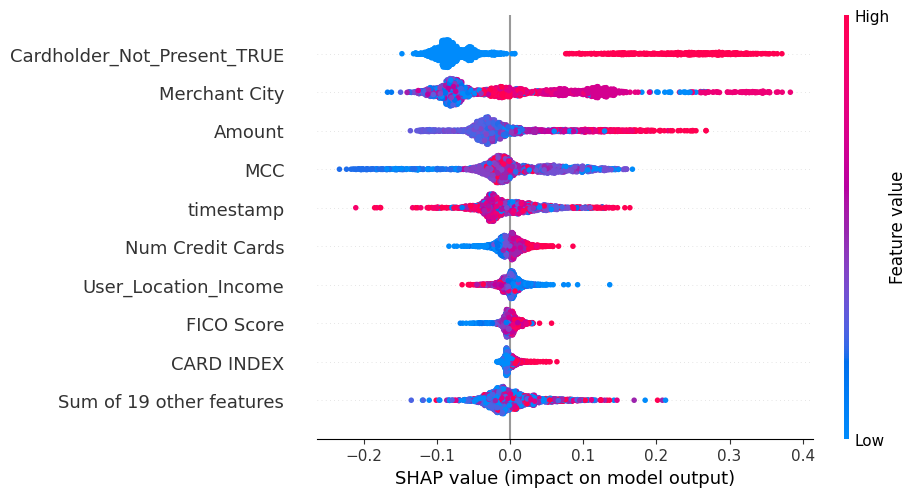

In [134]:
# Produce a Beeswarm for the global model
shap.plots.beeswarm(shap_values_global[:,:,1])

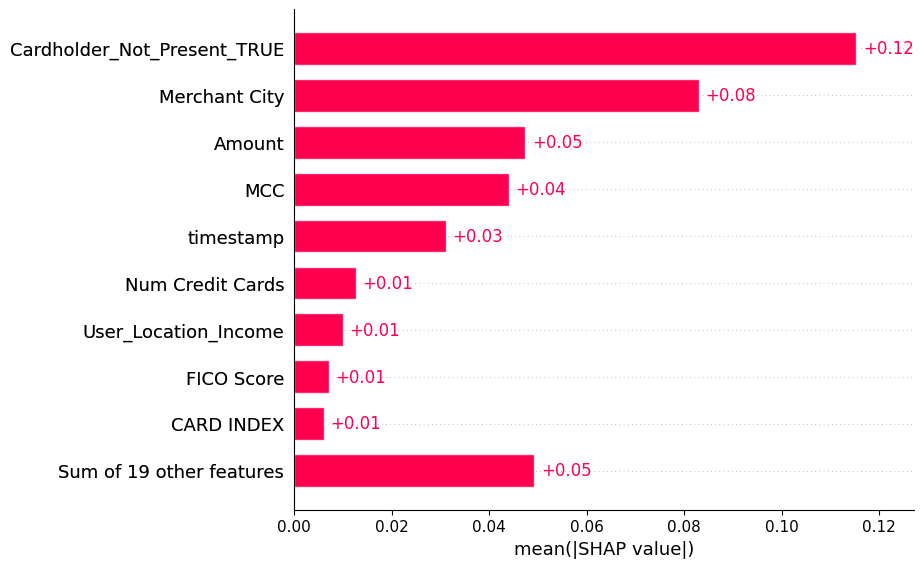

In [135]:
# Produce a Bar Chart for the global model
shap.plots.bar(shap_values_global[:,:,1])

In [136]:
#new = shap_values_global[:,:,1]

In [137]:
#  Shap Force Plot for single_instance
#  link = “identity” or “logit”
#  The transformation used when drawing the tick mark labels. Using “logit” will change log-odds numbers into probabilities.

shap.plots.force(explainer.expected_value[1], shap_values_local.values[:,:,1],single_instance,matplotlib=False,link='logit')

In [138]:
#  Shap Force Plot for single_instance.  
#  link = “identity” or “logit”
#  The transformation used when drawing the tick mark labels. Using “identity” will give log-odds numbers.

shap.plots.force(explainer.expected_value[1], shap_values_local.values[:,:,1],single_instance,matplotlib=False,link='identity')

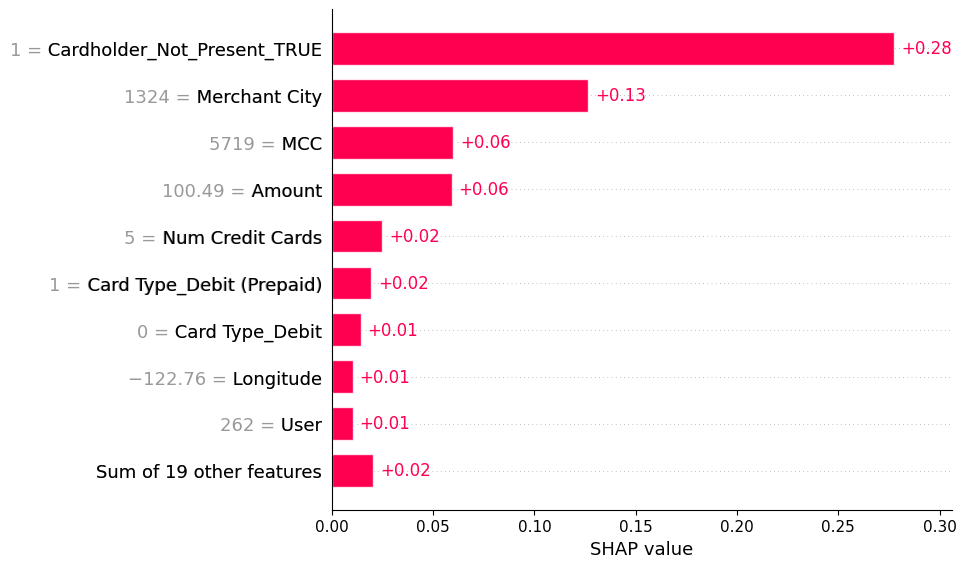

In [139]:
# Produce a Bar Chart for the local model
shap.plots.bar(shap_values_local[0,:,1])

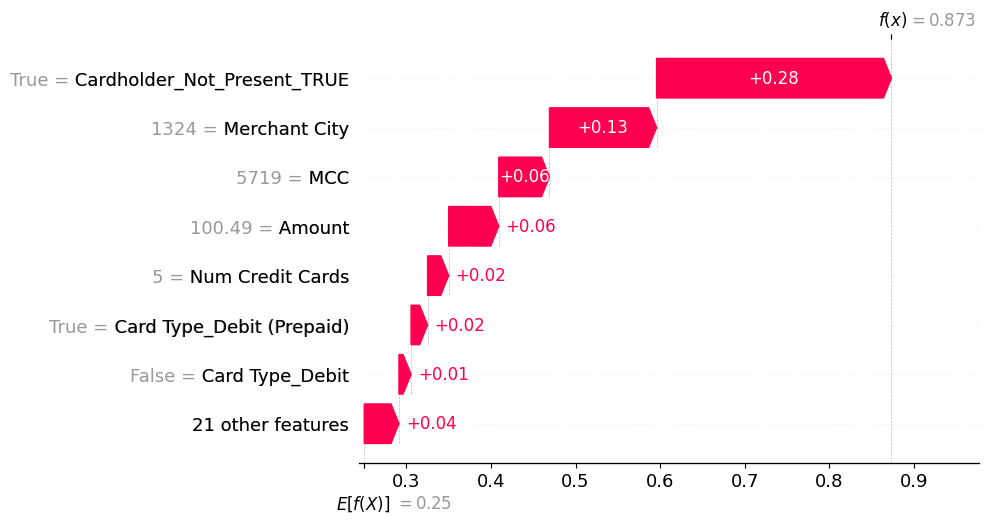

In [140]:
# the waterfall_plot shows how we get from shap_values.base_values to model.predict(X)[sample_ind]
# shap_values_local[0,:,1] is used because the required format is shap.plots.waterfall(explanation[id_to_explain,:,output_to_explain])

shap.plots.waterfall(shap_values_local[0,:,1], max_display=8)

Set up all the variables for a templated response

In [141]:
## Create two dataframes.  (1) with the shap values of the fraudulent transaction and (2) with just the original transaction
feature_names = single_instance.columns
rf_resultX = pd.DataFrame(shap_values_local.values[:,:,1], columns = feature_names).transpose()
rf_resultX.columns = ['shap value']
rf_resultX['abs shap value'] = rf_resultX["shap value"].abs()

top = 5
top_indices = rf_resultX["abs shap value"].nlargest(top).index
subset_df = rf_resultX.nlargest(top, 'abs shap value')

single_instance_df = single_instance.transpose()
single_instance_df.columns = ['fraud_transaction']

selected_values = single_instance_df.loc[top_indices, "fraud_transaction"]


In [142]:
df = subset_df.join(selected_values)
df = df.drop(['abs shap value'],axis = 1)
df = df[['fraud_transaction', 'shap value']]
#top_shap_values = rf_resultX[["abs shap value"].nlargest(top)]

In [143]:
## Get the indices of the top n absolute values in absolute shap values
top = 5
top_shap_values = rf_resultX["abs shap value"].nlargest(top)
top_indices = rf_resultX["abs shap value"].nlargest(top).index

## Use the indices to extract values from single_instance
selected_values = single_instance_df.loc[top_indices, "fraud_transaction"]
positive_contrib = rf_resultX.loc[top_indices, "shap value"]
print("Top 3 values by shap value:")
print(rf_resultX.loc[top_indices, "shap value"])

print("\nCorresponding values from single_instance:")
print(selected_values)

Top 3 values by shap value:
Cardholder_Not_Present_TRUE    0.277565
Merchant City                  0.126604
MCC                            0.059942
Amount                         0.059171
Num Credit Cards               0.024942
Name: shap value, dtype: float64

Corresponding values from single_instance:
Cardholder_Not_Present_TRUE      True
Merchant City                  1324.0
MCC                              5719
Amount                         100.49
Num Credit Cards                    5
Name: fraud_transaction, dtype: object


In [144]:
global_explain_shap = pd.DataFrame(shap_values_global.values[:,:,1],columns=feature_names)
global_explain_orig = pd.DataFrame(shap_values_global.data,columns=feature_names)

In [145]:
local_explain_shap = pd.DataFrame(shap_values_local.values[:,:,1],columns=feature_names)
local_explain_orig = pd.DataFrame(single_instance)

For Faithfulness, Try Ranking Features - rank features based on their absolute SHAP values, then compare this ranking to the importance of features in the ground truth (eg feature importance from the random forest).  If the rankings differ significantly, that implies a problem.
(1)  Get the mean absolute SHAP values and the ground truth (= feature importances from random forest)
(2) Sort both in descending order to get a ranked list for each
(3) Use rbo to determine ranking similarity

In [146]:

#RF_model_stdev = np.std([tree.feature_importances_ for tree in RF_model.estimators_], axis=0)

In [147]:
# Create a pandas series of random forest feature importances
importances = RF_model.feature_importances_
feature_names = single_instance.columns
RF_model_importances = pd.Series(importances, index=feature_names)

In [148]:
# calculate the mean absolute value (mav) for each feature in shap_values_global.values
shap_mav = global_explain_shap.abs().mean()

In [149]:
# Rank the two lists
ranked_shapmav = shap_mav.sort_values(ascending=False).index.tolist()
ranked_rfimp = RF_model_importances.sort_values(ascending=False).index.tolist()

# create faithfulness score using rank-biased overlap
#Rank Biased Overlap (RBO): RBO is a measure that accounts for both rank order and importance. It generalizes the average-based overlap and is suitable for non-conjoint lists. The RBO score ranges from 0 to 1, where 1 indicates identical lists. 
# https://pypi.org/project/rbo/

faithfulness = rbo.RankingSimilarity(ranked_shapmav, ranked_rfimp).rbo()

In [150]:
print("The random forest model is currently working at mean f1 accuracy of %.3f" % mean(scores['test_f1']))

print("\nTransaction ",single_fraud_instance," is predicted fraudulent with prediction confidence ",format(fx.values, ".0%"))

print("\nThe most influential features driving this prediction are:\n",df)

print("\nThe SHAP explanation has a faithfulness score of",format(faithfulness, ".0%"))

The random forest model is currently working at mean f1 accuracy of 0.844

Transaction  [663]  is predicted fraudulent with prediction confidence  87%

The most influential features driving this prediction are:
                             fraud_transaction  shap value
Cardholder_Not_Present_TRUE              True    0.277565
Merchant City                          1324.0    0.126604
MCC                                      5719    0.059942
Amount                                 100.49    0.059171
Num Credit Cards                            5    0.024942

The SHAP explanation has a faithfulness score of 86%


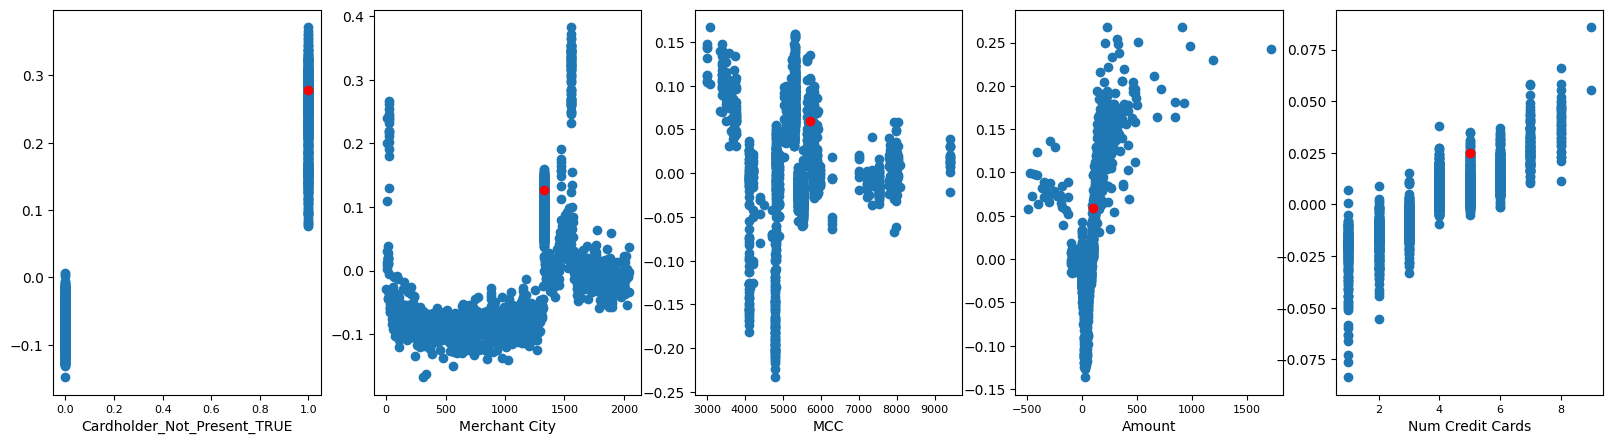

In [151]:
#  Print scatter plots of shap values for each of the nlargest columns.  Red dots indicate the values for the selected fraudulent transaction

columns = list(df.transpose().columns)
fig, ax = plt.subplots(1, len(columns), figsize = (20, 5))

for idx, col in enumerate(columns, 0):
    #ax[idx].plot(df['Cal'], df[col], 'o')
    ax[idx].scatter(global_explain_orig[col], global_explain_shap[col],alpha=1.0)
    ax[idx].scatter(local_explain_orig[col], local_explain_shap[col], color='red', alpha=1.0)
    ax[idx].set_xlabel(col)
    #ax[idx].set_title(col)

plt.show()